# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [413]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [14]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.decomposition import PCA

In [6]:
from sklearn.preprocessing import StandardScaler

In [162]:
import sys
sys.path.append('/wynton/group/ye/mincheol/Github/scrna-parameter-estimation/simplesc')
import scme, utils

In [8]:
data_path = '/wynton/group/ye/mincheol/parameter_estimation/interferon_data/'

### Select immune genes using GO annotations

In [403]:
go_annotations = pd.read_csv(data_path + '../GO_annotations-9606-inferred-allev.tsv', sep='\t')
go_annotations['gene'] = go_annotations['gene_symbols'].apply(lambda x: x.split('|'))
go_annotations = go_annotations\
    .query('go_domain == "biological_process"')\
    .explode('gene')[['go_name', 'gene']]

In [407]:
immune_genes = go_annotations[go_annotations.go_name.str.contains('immune')].gene.drop_duplicates().tolist()

In [411]:
genes_of_interest = list(set(adata.var.index) & set(immune_genes))

In [414]:
with open(data_path + 'immune_genes.pkl', 'wb') as f:
    pkl.dump(genes_of_interest, f)

### Perform some basic filtering

In [20]:
adata = sc.read(data_path + 'interferon.raw.h5ad')
adata = adata[:, adata.var.index.map(lambda x: x[:2] != 'HB')]

In [21]:
adata.obs.cell.value_counts()

CD4 T cells          10373
CD14+ Monocytes       5355
B cells               2570
CD8 T cells           2039
NK cells              1991
FCGR3A+ Monocytes     1592
Dendritic cells        432
Megakaryocytes         208
Name: cell, dtype: int64

In [22]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

Trying to set attribute `.obs` of view, making a copy.


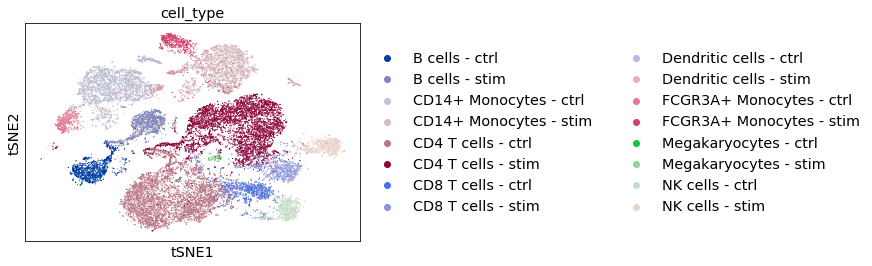

In [23]:
sc.pl.tsne(adata, color='cell_type')

In [24]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [25]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 1880


In [26]:
def density_scatterplot(a,b, s=1, cmap='Reds', kde=None):
    # Calculate the point density
    condition = np.isfinite(a) & np.isfinite(b)
    x = a[condition]
    y = b[condition]
    xy = np.vstack([x,y])
    z = stats.gaussian_kde(xy, bw_method=kde)(xy)
    print(z)
    plt.scatter(x, y, c=z, s=s, edgecolor='', cmap=cmap)
    

def robust_correlation(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    return stats.spearmanr(x,y)

def robust_linregress(a, b):
    
    condition = (np.isfinite(a) & np.isfinite(b))
    x = a[condition]
    y = b[condition]
    
    print(x.min())
    
    return stats.linregress(x,y)

def robust_hist(x, **kwargs):
    
    condition = np.isfinite(x)
    plt.hist(x[condition], **kwargs)

### Observed $\mu$-$CV^{2}$ Relationship

In [ ]:
imp.reload(scme)
estimator = scme.SingleCellEstimator(
    adata=adata, 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

In [151]:
estimator.estimate_beta_sq(tolerance=3)

Computing observed moments for: CD4 T cells - ctrl
Computing observed moments for: CD4 T cells - stim


In [152]:
estimator.estimate_parameters()

In [25]:
estimator.noise_level

0.2049755522580501

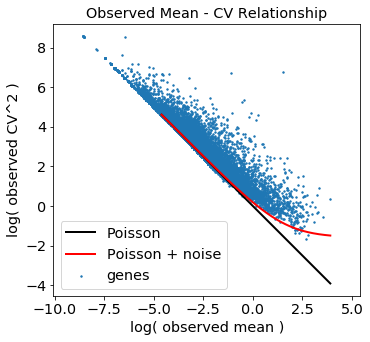

In [30]:
estimator.plot_cv_mean_curve()

### Residual variance

In [48]:
estimator.estimate_parameters()

In [49]:
est_mean = np.concatenate([estimator.estimated_central_moments[ct]['first'] for ct in estimator.groups])
est_var = np.concatenate([estimator.estimated_central_moments[ct]['second'] for ct in estimator.groups])
est_disp = est_var/est_mean
est_cv = est_var/est_mean**2

[0.02428444 0.00740224 0.00643607 ... 0.17376027 0.06297896 0.03336932]


Text(0,0.5,'log( estimated true variance )')

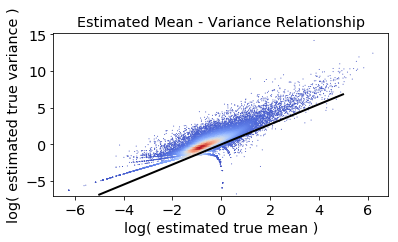

In [52]:
plt.figure(figsize=(6, 3))
density_scatterplot(
    np.log(est_mean),
    np.log(est_var),
    s=1, 
    cmap='coolwarm')
x_fit = np.arange(-5, 5, 0.01)
y_fit = x_fit*estimator.mean_var_slope
plt.plot(x_fit, y_fit, color='k', lw=2)
plt.ylim(-7,)
plt.title('Estimated Mean - Variance Relationship');
plt.xlabel('log( estimated true mean )')
plt.ylabel('log( estimated true variance )')

[0.02428444 0.00740224 0.00643607 ... 0.17376027 0.06297896 0.03336932]


Text(0,0.5,'log( residual variance )')

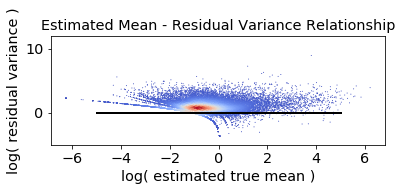

In [56]:
plt.figure(figsize=(6, 2))
density_scatterplot(
    np.log(est_mean),
    np.log(est_var) - estimator.mean_var_slope*np.log(est_mean),
    s=1, 
    cmap='coolwarm')
plt.plot([-5, 5], np.array([0, 0]), color='k', lw=2)
plt.ylim(-5,12)
plt.title('Estimated Mean - Residual Variance Relationship');
plt.xlabel('log( estimated true mean )')
plt.ylabel('log( residual variance )')

### CD4 T cell analysis

In [150]:
imp.reload(scme)
estimator = scme.SingleCellEstimator(
    adata=adata[adata.obs['cell'] == 'CD4 T cells', :].copy(), 
    group_label='cell_type',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

In [151]:
estimator.estimate_beta_sq(tolerance=3)

Computing observed moments for: CD4 T cells - ctrl
Computing observed moments for: CD4 T cells - stim


In [152]:
estimator.estimate_parameters()

In [153]:
ct = 'CD4 T cells'

In [155]:
%%time
imp.reload(scme)
estimator.compute_confidence_intervals_1d(
    groups=[ct + ' - ctrl', ct + ' - stim'],
    groups_to_compare=[(ct + ' - ctrl', ct + ' - stim')])

Gamma RVs generated..
CPU times: user 1min 50s, sys: 450 ms, total: 1min 50s
Wall time: 1min 50s


In [ ]:
imp.reload(utils)
upregulated_genes = utils.get_differential_genes(
    adata.var.index.tolist(), 
    estimator.hypothesis_test_result_1d,
    ct + ' - ctrl',
    ct + ' - stim',
    which='mean',
    direction='increase',
    sig=0.1, 
    num_genes=1000)

In [375]:
inc_var_genes = utils.get_differential_genes(
    adata.var.index.tolist(), 
    estimator.hypothesis_test_result_1d,
    ct + ' - ctrl',
    ct + ' - stim',
    which='variance',
    direction='increase',
    sig=0.15, 
    num_genes=1000)
dec_var_genes = utils.get_differential_genes(
    adata.var.index.tolist(), 
    estimator.hypothesis_test_result_1d,
    ct + ' - ctrl',
    ct + ' - stim',
    which='variance',
    direction='decrease',
    sig=0.15, 
    num_genes=1000)

In [397]:
up_inc_var = upregulated_genes\
    .merge(inc_var_genes, on='gene', how='inner', suffixes=('_de', '_dv'))
up_dec_var = upregulated_genes\
    .merge(dec_var_genes, on='gene', how='inner', suffixes=('_de', '_dv'))

In [398]:
up_inc_var

,pval_de,fdr_de,effect_size_de,gene,rank_de,pval_dv,fdr_dv,effect_size_dv,rank_dv
0,1.623588e-07,0.000008,0.492016,CCR7,23,3.799620e-03,0.120879,0.511030,29
1,1.878842e-07,0.000008,3.092909,TNFSF10,26,4.091971e-05,0.004042,1.119020,13
2,6.993094e-07,0.000015,0.381371,SRM,50,3.799620e-03,0.120879,0.703132,28
3,7.704338e-07,0.000016,0.990211,IRF1,51,5.599440e-03,0.143975,0.630926,37
4,9.914582e-07,0.000018,1.552170,PRF1,56,2.037870e-05,0.002493,0.990799,10
5,1.112283e-06,0.000019,3.192419,IFI27,61,3.723356e-07,0.000116,1.332213,4
6,1.155896e-06,0.000019,3.102690,IFITM3,62,2.541243e-07,0.000108,0.929113,2
7,1.281356e-06,0.000019,0.483148,ZC3HAV1,65,7.999200e-04,0.041707,0.844556,19
8,2.082402e-06,0.000024,0.168159,HSPA5,87,2.997340e-05,0.003309,1.184036,11
9,7.544188e-06,0.000052,0.577428,FUNDC1,133,5.399460e-03,0.143975,1.749850,36


In [399]:
up_dec_var

,pval_de,fdr_de,effect_size_de,gene,rank_de,pval_dv,fdr_dv,effect_size_dv,rank_dv
0,1.233110e-08,0.000003,0.767666,GIMAP4,6,1.291838e-05,0.002425,0.839443,3
1,5.148650e-08,0.000006,2.632958,IFI44,13,1.461069e-04,0.010157,1.550909,11
2,1.644337e-07,0.000008,0.140271,TRAT1,25,9.999000e-04,0.049390,0.881253,19
3,3.258228e-07,0.000010,3.307848,IFI44L,30,1.549690e-05,0.002489,1.865907,4
4,6.082355e-07,0.000014,0.763173,SELL,43,7.999200e-04,0.041707,0.560770,17
5,2.087332e-06,0.000024,0.262437,CYCS,86,9.999000e-04,0.049390,1.037301,18
6,2.901903e-06,0.000029,0.868869,ARHGAP25,95,1.599840e-03,0.066731,0.928255,22
7,3.389279e-06,0.000032,1.497907,PARP11,100,1.821716e-05,0.002489,0.950234,5
8,7.237614e-06,0.000051,4.624475,IFIT1,131,1.999800e-04,0.012444,3.780797,13
9,1.784071e-05,0.000097,4.607336,IFIT3,160,1.999800e-04,0.012444,4.622662,12


## Effect of interferon stimulation across cell types

### Read 1D Hypothesis test results and confidence intervals

### Expression changes across CT for a gene

In [602]:
with open(data_path + 'stim_effect_1d_params.pkl', 'rb') as f:
    parameter_dict = pkl.load(f)

In [603]:
with open(data_path + 'stim_effect_ci_1d.pkl', 'rb') as f:
    ci_dict = pkl.load(f)

In [425]:
parameter_dict['CD4 T cells' + ' - ctrl']

{'mean': array([0.11641452, 0.448196  , 0.8653453 , ..., 0.56849104, 0.2658132 ,
        0.40745094], dtype=float32),
 'log_mean': array([-2.150598  , -0.8025247 , -0.14462666, ..., -0.56476974,
        -1.3249614 , -0.8978347 ], dtype=float32),
 'residual_var': array([3.75603655, 2.0069145 , 2.94908531, ..., 2.53497887, 1.12987436,
        1.90244249]),
 'log_residual_var': array([1.32336429, 0.69659847, 1.08149506, ..., 0.9301853 , 0.12210644,
        0.64313858])}

In [426]:
def plot_exp_changes_across_ct(gene, parameter_dict, ci_dict, barwidth=0.3):
    
    plt.figure(figsize=(11, 6))
    
    plt.subplots_adjust(hspace=0.1)
    
    groups = adata.obs['cell'].drop_duplicates()
    
    labels = adata.obs['cell'].drop_duplicates()
    labels = [label.replace(' ', '\n') for label in labels]
    labels[-2] = 'Megaka\nryocytes'
    
    gene_idx = np.where(adata.var.index == gene)[0][0]
    
    ctrl_means = np.array([parameter_dict[group + ' - ctrl']['mean'][gene_idx] for group in groups])
    stim_means = np.array([parameter_dict[group + ' - stim']['mean'][gene_idx] for group in groups])
    ctrl_means_ci = np.array([ci_dict[group + ' - ctrl']['log1p_mean'][gene_idx] for group in groups])
    stim_means_ci = np.array([ci_dict[group + ' - stim']['log1p_mean'][gene_idx] for group in groups])
    
    ctrl_vars = np.array([parameter_dict[group + ' - ctrl']['residual_var'][gene_idx] for group in groups])
    stim_vars = np.array([parameter_dict[group + ' - stim']['residual_var'][gene_idx] for group in groups])
    ctrl_vars_ci = np.array([ci_dict[group + ' - ctrl']['log1p_residual_var'][gene_idx] for group in groups])
    stim_vars_ci = np.array([ci_dict[group + ' - stim']['log1p_residual_var'][gene_idx] for group in groups])
    
    ctrl_loc = np.arange(len(ctrl_means)) - barwidth/2
    stim_loc = np.arange(len(ctrl_means)) + barwidth/2
    
    plt.subplot(2, 1, 1)
    plt.title('{} Expression in response to IFN-B'.format(gene))
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_means+1), 
        width=barwidth,
        yerr=ctrl_means_ci,
        capsize=5
    )
    plt.bar(
        stim_loc, 
        np.log(stim_means+1), 
        width=barwidth,
        yerr=stim_means_ci,
        capsize=5
    )
    plt.xticks([])
    plt.legend(['control', 'IFN-B'])
    plt.ylabel('Log(mean+1)')
    plt.ylim(0, max(np.log(ctrl_means+1).max(), np.log(stim_means+1).max()) + 1)
    
    plt.subplot(2, 1, 2)
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_vars+1), 
        width=barwidth,
        yerr=ctrl_vars_ci,
        capsize=5
    )
    plt.bar(
        stim_loc, 
        np.log(stim_vars+1), 
        width=barwidth,
        yerr=stim_vars_ci,
        capsize=5
    )
    plt.xticks(np.arange(len(ctrl_means)), labels)
    plt.ylim(0, max(np.log(ctrl_vars+1).max(), np.log(stim_vars+1).max()) + 1)
    plt.ylabel('Log(res.variance+1)')

In [442]:
large_effect_list = upregulated_genes.sort_values('effect_size', ascending=False).gene.tolist()[:40]

In [445]:
across_ct_genes = ['TNFSF10', 'IFI44L', 'TRIM22']

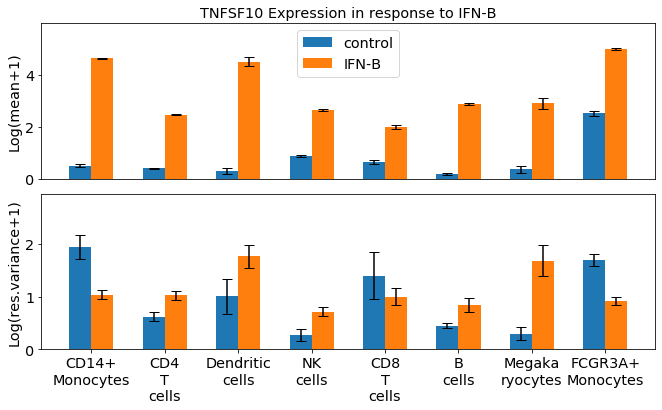

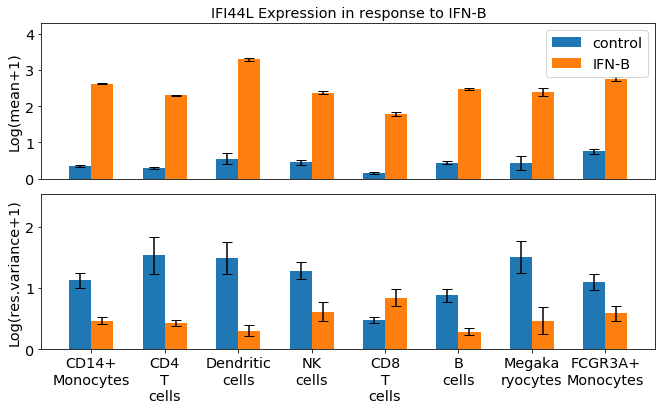

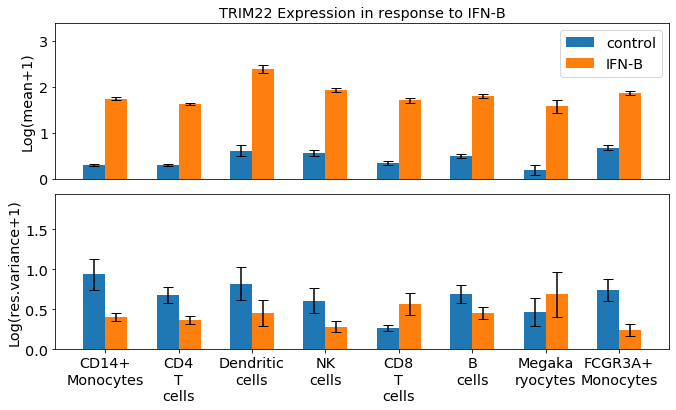

In [446]:
for gene in across_ct_genes:
    try:
        plot_exp_changes_across_ct(gene, parameter_dict, ci_dict)
    except:
        continue
#     plt.savefig(data_path + 'figures/{}_across_ct.pdf'.format(gene))
#     plt.savefig(data_path + 'figures/{}_across_ct.png'.format(gene))

### Expression changes across different genes for a CT

In [452]:
def plot_exp_across_genes(genes, ct, parameter_dict, ci_dict, barwidth=0.3):

    plt.figure(figsize=(len(genes)*1.5, 7))
    
    genes_idx = [np.where(adata.var.index == gene)[0][0] for gene in genes]
    
    ctrl_means = np.array([parameter_dict[ct + ' - ctrl']['mean'][gene_idx] for gene_idx in genes_idx])
    stim_means = np.array([parameter_dict[ct + ' - stim']['mean'][gene_idx] for gene_idx in genes_idx])
    ctrl_means_ci = np.array([ci_dict[ct + ' - ctrl']['log1p_mean'][gene_idx] for gene_idx in genes_idx])
    stim_means_ci = np.array([ci_dict[ct + ' - stim']['log1p_mean'][gene_idx] for gene_idx in genes_idx])

    ctrl_vars = np.array([parameter_dict[ct + ' - ctrl']['residual_var'][gene_idx] for gene_idx in genes_idx])
    stim_vars = np.array([parameter_dict[ct + ' - stim']['residual_var'][gene_idx] for gene_idx in genes_idx])
    ctrl_vars_ci = np.array([ci_dict[ct + ' - ctrl']['log1p_residual_var'][gene_idx] for gene_idx in genes_idx])
    stim_vars_ci = np.array([ci_dict[ct + ' - stim']['log1p_residual_var'][gene_idx] for gene_idx in genes_idx])
    
    ctrl_loc = np.arange(len(ctrl_means)) - barwidth/2
    stim_loc = np.arange(len(ctrl_means)) + barwidth/2
    labels = genes
    
    plt.subplot(2, 1, 1)
    plt.title('Expression changes in {}'.format(ct))
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_means+1), 
        width = barwidth,
        yerr=ctrl_means_ci,
        capsize=5
    )
    plt.bar(
        stim_loc, 
        np.log(stim_means+1), 
        width = barwidth,
        yerr=stim_means_ci,
        capsize=5
    )
    plt.ylim(0, max(np.log(ctrl_means+1).max(), np.log(stim_means+1).max()) + 0.5)
    plt.xticks([])
    plt.legend(['control', 'IFN-B'])
    plt.ylabel('Log(mean+1)')
    
    plt.subplot(2, 1, 2)
    plt.bar(
        ctrl_loc, 
        np.log(ctrl_vars+1), 
        width = barwidth,
        yerr=ctrl_vars_ci,
        capsize=5
    )
    plt.bar(
        stim_loc, 
        np.log(stim_vars+1), 
        width = barwidth,
        yerr=stim_vars_ci,
        capsize=5
    )
    plt.ylim(0, max(np.log(ctrl_vars+1).max(), np.log(stim_vars+1).max()) + 1.4)
    plt.xticks(np.arange(len(ctrl_means)), labels)
    plt.ylabel('Log(res.variance+1)')

In [463]:
genes_1 = ['PTCD3', 'CDK12', 'RAB3GAP1', 'FAS', 'SETX']
genes_1 = ['HSPA5', 'KDM5A', 'FUNDC1', 'SELL', 'TRAT1']
# both sig, only var sig, both sig, both sig, both sig, only var

In [464]:
genes_2 = ['IFIT1', 'IFIT2', 'IFIT3', 'IFITM3', 'IFIT5']

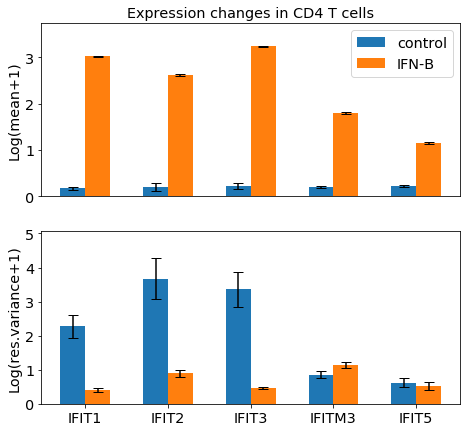

In [465]:
plot_exp_across_genes(genes_2, 'CD4 T cells', parameter_dict, ci_dict, barwidth=0.3)


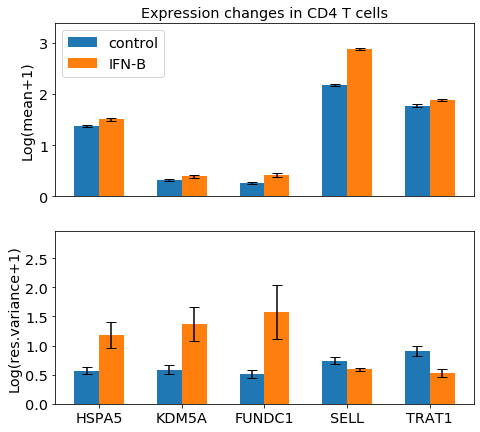

In [466]:
plot_exp_across_genes(genes_1, 'CD4 T cells', parameter_dict, ci_dict, barwidth=0.3)



### Pseudotime interferon stimulation analysis

In [606]:
with open(data_path + 'stim_effect_1d.pkl', 'rb') as f:
    ht_dict = pkl.load(f)

In [607]:
ht_dict

{('CD14+ Monocytes - ctrl',
  'CD14+ Monocytes - stim'): {'de_diff': array([ 4.6774931 , -0.76712608, -0.54991722, ..., -0.76712549,
          0.7239545 , -1.26310468]), 'de_pval': array([6.87563548e-07, 6.49935006e-02, 1.67583242e-01, ...,
         3.21245600e-05, 2.81323676e-07, 7.51791497e-05]), 'de_fdr': array([1.53801417e-05, 9.21681417e-02, 2.14648201e-01, ...,
         9.11813419e-05, 1.22931904e-05, 1.81803890e-04]), 'dv_diff': array([ 0.02467893, -0.7767843 , -0.93092602, ..., -0.21516966,
         -0.49144085, -0.2651998 ]), 'dv_pval': array([0.84531547, 0.43675632, 0.19378062, ..., 0.79492051, 0.1259874 ,
         0.76072393]), 'dv_fdr': array([0.93946014, 0.70756033, 0.4959515 , ..., 0.91232173, 0.40610372,
         0.89554156])},
 ('CD4 T cells - ctrl',
  'CD4 T cells - stim'): {'de_diff': array([ 1.23545694, -0.14174497,  0.19342439, ..., -0.17124599,
         -1.04069448,  0.09139717]), 'de_pval': array([4.16709748e-05, 2.45575442e-01, 2.93970603e-02, ...,
         9.699

In [566]:
cd4_pt_df = pd.read_csv(data_path + 'cd4_timepoints.csv', index_col=0)
cd4_adata = adata[adata.obs.cell == 'CD4 T cells'].copy()
cd4_adata.obs['stim_tp'] = cd4_pt_df['stim_tp'].astype(str)
cd4_stim_adata = cd4_adata[cd4_adata.obs.stim == 'stim'].copy()
cd4_stim_adata.obs['stim_tp'] = cd4_stim_adata.obs['stim_tp'].replace('5', '4')

In [570]:
imp.reload(scme)
estimator = scme.SingleCellEstimator(
    adata=cd4_stim_adata, 
    group_label='stim_tp',
    n_umis_column='n_counts',
    num_permute=10000,
    beta=0.1)

estimator.estimate_beta_sq(tolerance=3)

Computing observed moments for: 2
Computing observed moments for: 0
Computing observed moments for: 1
Computing observed moments for: 3
Computing observed moments for: 4


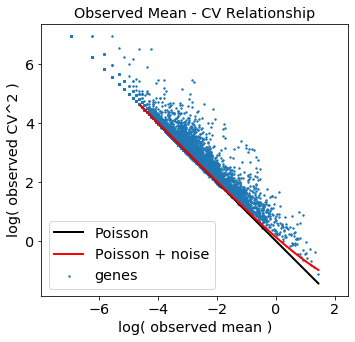

In [572]:
estimator.plot_cv_mean_curve()

In [573]:
estimator.estimate_parameters()

In [574]:
estimator.compute_confidence_intervals_1d(
    groups=estimator.groups,
    groups_to_compare=[])

Gamma RVs generated..


In [627]:
def plot_param_trajectory(gene, estimator, x_axis_width, y_axis_width):
    
    groups = [str(i) for i in range(5 if gene != 'ARL4A' else 4)] 
    
    gene_idx = np.where(adata.var.index == gene)[0][0]
    
    means = np.array([estimator.parameters[group]['log_mean'][gene_idx] for group in groups])
    dispersions = np.array([estimator.parameters[group]['log_residual_var'][gene_idx] for group in groups])
    
    means_ci = [estimator.parameters_confidence_intervals[group]['log_mean'][gene_idx] for group in groups]
    dispersions_ci = [estimator.parameters_confidence_intervals[group]['log_residual_var'][gene_idx] for group in groups]
    
    plt.errorbar(
        x=means, 
        y=dispersions,
        xerr=means_ci,
        yerr=dispersions_ci,
        fmt='.-',
        capsize=2,
        ecolor='k')
    plt.title(gene)

    offset=0.03
    for i, label in enumerate(groups):
        mean_offset = -0.03 if i % 2 == 0 else 0
        plt.annotate(label, (means[i] + mean_offset, dispersions[i]+dispersions_ci[i]+offset))
    
    axes = plt.gca()
    ymin, ymax = axes.get_ylim()
    xmin, xmax = axes.get_xlim()
    
    ymid = (ymin + ymax)/2
    xmid = (xmin + xmax)/2
    
    #axes.set_xlim([xmid - x_axis_width, xmid + x_axis_width])
    axes.set_ylim([ymin, ymax + 0.2])
    
    axes.xaxis.set_major_locator(plt.MultipleLocator(0.5))
    
    

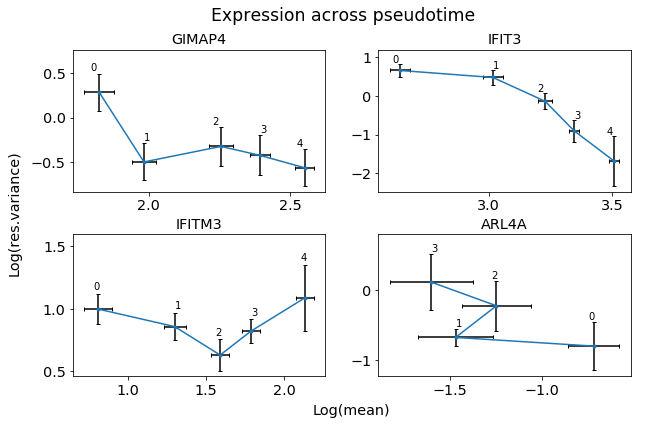

In [628]:
x_width = 0.8
y_width = 2
fig = plt.figure(figsize=(10, 6))
plt.suptitle('Expression across pseudotime')
plt.subplots_adjust(hspace=0.3, wspace=0.21)
plt.subplot(2, 2, 1)
plot_param_trajectory(
    gene='GIMAP4', 
    estimator=estimator,
    y_axis_width=y_width,
    x_axis_width=x_width)
plt.subplot(2, 2, 2)
plot_param_trajectory(
    gene='IFIT3', 
    estimator=estimator,
    y_axis_width=y_width,
    x_axis_width=x_width)
plt.subplot(2, 2, 3)
plot_param_trajectory(
    gene='IFITM3', 
    estimator=estimator,
    y_axis_width=y_width,
    x_axis_width=x_width)
plt.subplot(2, 2, 4)
plot_param_trajectory(
    gene='ARL4A', 
    estimator=estimator,
    y_axis_width=y_width,
    x_axis_width=x_width)

ax = fig.add_subplot(111, frameon=False);
plt.tick_params(
    which='both',
    length=0,
    labelcolor='none', 
    top='off', 
    bottom='off', 
    left='off', 
    right='off');
ax.set_xlabel('Log(mean)', labelpad=10);
ax.set_ylabel('Log(res.variance)', labelpad=25);

### TF - gene differential correlation

In [629]:
with open(data_path + 'stim_effect_2d.pkl', 'rb') as f:
    dc_result = pkl.load(f)
with open(data_path + 'stim_effect_ci_2d.pkl', 'rb') as f:
    corr_ci = pkl.load(f)

In [631]:
ct = 'CD4 T cells'

In [653]:
idxs_1 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_1']
idxs_2 = dc_result[(ct + ' - ctrl', ct + ' - stim')]['gene_idx_2']

In [651]:
gene_pair_idx = np.where(dc_result[(ct + ' - ctrl', ct + ' - stim')]['dc_fdr'] < 0.1)

In [665]:
dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_1'][gene_pair_idx]

array([ 0.17061928,  0.04288078, -0.03751681,  0.16342578,  0.0664182 ,
       -0.02571221, -0.09486406,  0.11890602, -0.09392146, -0.12546095,
        0.13308962, -0.02633542, -0.0787876 , -0.19500224, -0.1067041 ,
       -0.04458095, -0.0505138 ,  0.20234977,  0.07852204, -0.17613889,
       -0.00338497,  0.00669049,  0.00636057,  0.00322307,  0.00541832,
       -0.00465474,  0.0259693 , -0.00315265, -0.00232153, -0.00896896,
        0.0015981 , -0.00338497, -0.00705325,  0.00135808, -0.00071758,
       -0.00916566, -0.00195052, -0.03154148,  0.06472605,  0.07595083,
        0.03565295,  0.09511898,  0.1185483 ])

In [664]:
dc_result[(ct + ' - ctrl', ct + ' - stim')]['corr_2'][gene_pair_idx]

array([-0.26803504,  0.30064239, -0.58625711, -0.15775914,  0.21545698,
       -0.08510973, -0.02341297, -0.11521582,  0.29280633, -0.05762649,
       -0.03378943,  0.10400673,  0.28325772,  0.14715242, -0.04301132,
       -0.53199443, -0.30576343,  0.47459915, -0.08281432,  0.11299282,
       -0.01994916,  0.6775416 ,  0.26257988, -0.05528704, -0.06578961,
       -0.11849974,  0.42611901, -0.02985135,  0.15831033,  0.40693866,
        0.66802979,  0.55639246,  0.40856456, -0.06965213, -0.00902552,
        0.19336807, -0.01664206, -0.11864059, -0.06981506, -0.10978611,
       -0.42159733, -0.15896295, -0.13212727])

In [663]:
dc_result[(ct + ' - ctrl', ct + ' - stim')]['dc_diff'][gene_pair_idx]

array([-0.43865432,  0.25776161, -0.5487403 , -0.32118492,  0.14903878,
       -0.05939751,  0.0714511 , -0.23412184,  0.38672778,  0.06783446,
       -0.16687905,  0.13034215,  0.36204532,  0.34215466,  0.06369277,
       -0.48741348, -0.25524964,  0.27224937, -0.16133636,  0.28913171,
       -0.01656418,  0.67085111,  0.25621931, -0.05851012, -0.07120793,
       -0.113845  ,  0.40014971, -0.0266987 ,  0.16063186,  0.41590762,
        0.6664317 ,  0.55977743,  0.41561781, -0.07101021, -0.00830794,
        0.20253373, -0.01469154, -0.08709911, -0.13454111, -0.18573695,
       -0.45725028, -0.25408193, -0.25067557])

In [659]:
genes = list(zip(
    adata.var.index[idxs_1[gene_pair_idx[0]]], 
    adata.var.index[idxs_2[gene_pair_idx[1]]]))

In [660]:
genes

[('STAT3', 'IFIT1'),
 ('STAT3', 'BATF'),
 ('STAT3', 'IFI6'),
 ('STAT3', 'IFIT3'),
 ('STAT3', 'HSPA1A'),
 ('STAT3', 'DEFB1'),
 ('STAT4', 'CLEC5A'),
 ('STAT4', 'GYPC'),
 ('STAT4', 'ICOS'),
 ('STAT4', 'THBS1'),
 ('STAT4', 'IGLL5'),
 ('STAT6', 'CD83'),
 ('STAT6', 'IGSF6'),
 ('STAT6', 'ERCC1'),
 ('STAT6', 'THBS1'),
 ('IRF1', 'IFI6'),
 ('IRF1', 'MT2A'),
 ('IRF1', 'NFKBIA'),
 ('IRF1', 'CD38'),
 ('IRF1', 'CLPTM1'),
 ('IRF8', 'HLA-DRB5'),
 ('IRF8', 'HLA-DQA1'),
 ('IRF8', 'KLF6'),
 ('IRF8', 'RNF168'),
 ('IRF8', 'NHLRC3'),
 ('IRF8', 'MT2A'),
 ('IRF8', 'HLA-DRB1'),
 ('IRF8', 'SLAMF7'),
 ('IRF8', 'NFKBIA'),
 ('IRF8', 'PMAIP1'),
 ('IRF8', 'HLA-DQB1'),
 ('IRF8', 'MNDA'),
 ('IRF8', 'DUSP10'),
 ('IRF8', 'PSMD3'),
 ('IRF8', 'IGLL5'),
 ('IRF8', 'GBP4'),
 ('IRF8', 'DEFB1'),
 ('IRF9', 'HLA-DRB5'),
 ('IRF9', 'KLRC1'),
 ('IRF9', 'IFIT2'),
 ('IRF9', 'IFI6'),
 ('IRF9', 'IFIT3'),
 ('IRF9', 'GZMB')]

In [650]:
gene_pair_idx

[(array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
         4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5]),),
 (array([  8,  16, 137, 165, 208, 417,  17, 125, 176, 315, 371,  91, 195,
         231, 315, 137, 153, 207, 372, 404,  25,  28,  50,  66,  82, 153,
         171, 190, 207, 220, 293, 297, 318, 364, 371, 405, 417,  25,  56,
          57, 137, 165, 337]),)]

In [645]:
gene_pair_idx[1]

array([  8,  16, 137, 165, 208, 417,  17, 125, 176, 315, 371,  91, 195,
       231, 315, 137, 153, 207, 372, 404,  25,  28,  50,  66,  82, 153,
       171, 190, 207, 220, 293, 297, 318, 364, 371, 405, 417,  25,  56,
        57, 137, 165, 337])

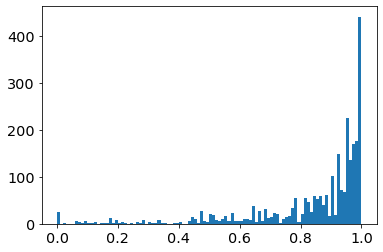

In [641]:
plt.hist(dc_result[(ct + ' - ctrl', ct + ' - stim')]['dc_fdr'].reshape(-1), bins=100);

In [557]:
imp.reload(scme)
estimator = scme.SingleCellEstimator(
    adata=adata[adata.obs.cell == 'NK cells', :], 
    group_label='stim',
    n_umis_column='n_counts',
    num_permute=100,
    beta=0.1)

estimator.estimate_beta_sq(tolerance=3)

Computing observed moments for: ctrl
Computing observed moments for: stim


In [558]:
estimator.estimate_parameters()

In [559]:
estimator.compute_confidence_intervals_2d(
    gene_list_1=['STAT3', 'STAT4'],
    gene_list_2=['IRF1', 'IRF8'],
    groups=['ctrl', 'stim'],
    groups_to_compare=[('ctrl', 'stim')])

Gamma RVs generated..


In [561]:
idxs_1 = estimator.hypothesis_test_result_2d[('ctrl', 'stim')]['gene_idx_1']
idxs_2 = estimator.hypothesis_test_result_2d[('ctrl', 'stim')]['gene_idx_2']

In [564]:
estimator.parameters_confidence_intervals['ctrl']['corr'][idxs_1, :][:, idxs_2]

array([[0.11974774, 0.1121308 ],
       [0.34027101, 0.23082148]])

(array([ 1.,  7., 11., 12., 14., 21., 16., 12.,  3.,  3.]),
 array([-0.16946335, -0.11156026, -0.05365718,  0.00424591,  0.062149  ,
         0.12005209,  0.17795517,  0.23585826,  0.29376135,  0.35166443,
         0.40956752]),
 <a list of 10 Patch objects>)

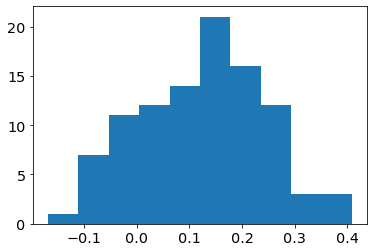

In [565]:
plt.hist(lols[1]['ctrl'])

In [547]:
# bootstrap observed prod
lols[0]['ctrl']

array([0.01512499, 0.04507274, 0.03269162, 0.01903197, 0.02813052,
       0.02522378, 0.03266247, 0.02009801, 0.01824844, 0.02284881,
       0.03142036, 0.03993311, 0.03246627, 0.04048396, 0.06068127,
       0.02298818, 0.0442047 , 0.05295338, 0.03626216, 0.02446335,
       0.02872245, 0.03278905, 0.02694285, 0.0149884 , 0.04267107,
       0.02630317, 0.03192859, 0.01895463, 0.02144756, 0.01785127,
       0.02792843, 0.02488757, 0.03511019, 0.04792707, 0.02886803,
       0.01951885, 0.02019208, 0.02843866, 0.02419172, 0.05263584,
       0.01931807, 0.05519273, 0.02133945, 0.05267782, 0.03723521,
       0.01695893, 0.03483033, 0.0246568 , 0.01926071, 0.05507828,
       0.02174748, 0.0204896 , 0.02261732, 0.01782601, 0.04812281,
       0.0194297 , 0.02405793, 0.03072237, 0.02865022, 0.02452506,
       0.06909999, 0.01438329, 0.05882611, 0.03894443, 0.02716732,
       0.02605996, 0.01930223, 0.04545936, 0.03497471, 0.05061019,
       0.02452826, 0.02166513, 0.02050346, 0.01416352, 0.01655

In [532]:
# bootstrap estimated cov
lols[2]['ctrl']

array([-175.54680358, -153.03818685, -173.35768397, -262.72671174,
       -206.55280933, -178.98426805, -257.89817235, -161.89325867,
       -195.44767483, -251.91571026, -152.46163451, -181.79988265,
       -130.5956484 , -159.07049891, -200.72030415, -113.24831934,
       -213.21330926, -179.49883569, -204.59314523, -290.33599716,
       -250.2526381 , -135.22553984, -147.52926182, -238.39271205,
       -191.51935394, -183.84281897, -244.94670646, -247.31971565,
       -200.97314546, -187.78885377, -250.45934935, -148.59790576,
       -278.6505464 , -266.66821356, -190.34827136, -200.8347563 ,
       -157.1113622 , -175.59363452, -210.28160537, -185.41086767,
       -191.7174289 , -181.25352346, -175.65505608, -234.36791546,
       -193.2630389 , -173.81700774, -171.93296607, -148.19729858,
       -181.90144672, -215.09670178, -148.37557497, -270.16584995,
       -247.90053712, -284.45612352, -140.29377306, -146.77638162,
       -212.47388899, -244.21522242, -204.38752274, -260.59976

In [527]:
estimator.observed_moments['ctrl']['prod'][1579, 558]

0.02951967393796865

In [516]:
estimator.estimated_central_moments['ctrl']['prod'][1579, 558]

0.6323602193741968

In [ ]:
estimator.estimated_central_moments['ctrl']['prod'][0, 0]

In [518]:
estimator.estimated_central_moments['ctrl']['second'][558]

10.175021361724792

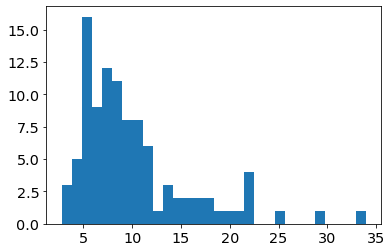

In [522]:
plt.hist(lols[-1]['ctrl'], bins=30);

In [496]:
estimator.parameters['ctrl']

{'mean': array([0.11641452, 0.448196  , 0.8653453 , ..., 0.56849104, 0.2658132 ,
        0.40745094], dtype=float32),
 'log_mean': array([-2.150598  , -0.8025247 , -0.14462666, ..., -0.56476974,
        -1.3249614 , -0.8978347 ], dtype=float32),
 'residual_var': array([2.40436402, 1.66253466, 2.72517142, ..., 2.17838308, 0.88189584,
        1.55294539]),
 'log_residual_var': array([ 0.87728543,  0.50834334,  1.00253133, ...,  0.7785829 ,
        -0.12568132,  0.44015338]),
 'corr': matrix([[ 1.        ,  0.21510243,  0.0922788 , ..., -0.04754155,
          -0.06869658,  0.0273915 ],
         [ 0.21510243,  1.        ,  0.33985688, ..., -0.01770838,
          -0.04491235, -0.03258216],
         [ 0.0922788 ,  0.33985688,  1.        , ..., -0.03220869,
          -0.09545098, -0.06097961],
         ...,
         [-0.04754155, -0.01770838, -0.03220869, ...,  1.        ,
          -0.01311631, -0.02907485],
         [-0.06869658, -0.04491235, -0.09545098, ..., -0.01311631,
           1.    

In [495]:
lols

{'ctrl': array([-51.27093864, -32.91376216, -40.587752  , -46.3672013 ,
        -35.77564578, -41.63025558, -42.88480138, -44.10467868,
        -53.25679757, -51.21164784, -40.26826364, -34.06411124,
        -51.25546632, -37.53903724, -34.4380588 , -43.70659938,
        -32.96192921, -38.3579352 , -42.8868795 , -45.23520992,
        -50.01980066, -49.17464451, -40.88508069, -43.8252825 ,
        -47.80746746, -52.82230161, -49.01517696, -52.02466927,
        -35.22250371, -40.78930525, -33.7949215 , -40.15090546,
        -30.72146507, -46.14791825, -42.62706511, -43.38477478,
        -48.06286302, -57.2125539 , -40.73144807, -32.35621568,
        -38.28018438, -50.29142428, -50.98942434, -44.6275759 ,
        -51.89072038, -44.13048029, -53.00759649, -37.74950633,
        -63.76234153, -37.78633027, -48.07873911, -33.9801575 ,
        -54.22502486, -39.86326084, -40.51766418, -32.60107881,
        -32.35892432, -49.14055536, -48.70391946, -40.78632599,
        -52.91010717, -45.884096

TypeError: '<' not supported between instances of 'NoneType' and 'float'

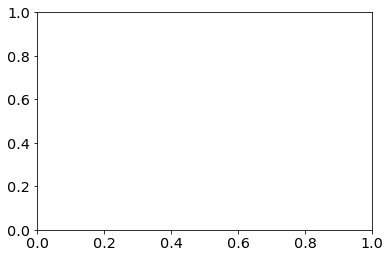

In [488]:
plt.hist(lols)

In [479]:
idxs_1 = estimator.hypothesis_test_result_2d[('ctrl', 'stim')]['gene_idx_1']
idxs_2 = estimator.hypothesis_test_result_2d[('ctrl', 'stim')]['gene_idx_2']

In [482]:
estimator.parameters_confidence_intervals['ctrl']

{'corr': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]])}

In [483]:
estimator.parameters_confidence_intervals['ctrl']['corr'][idxs_1, :][:, idxs_2]

array([[7.04790494, 1.34316866],
       [4.017259  , 1.00465865]])

In [471]:
corr_ci['']

{'CD14+ Monocytes - ctrl': {'corr': array([[ 8.49877924, 11.79768959,  4.35285228],
         [ 2.59029426,  3.28346838,  1.83302905],
         [ 5.12397771,  7.3871446 ,  3.25075039],
         [ 4.8390428 ,  8.31960509,  2.99245704],
         [ 2.63360798,  4.37454896,  1.7429339 ],
         [ 3.83274192,  6.1247583 ,  2.01987171]])},
 'CD14+ Monocytes - stim': {'corr': array([[ 5.81575411, 11.12406048,  5.23693244],
         [ 1.74487019,  3.02320875,  1.36151665],
         [ 3.40364218,  6.75797619,  2.70764788],
         [ 5.18374672, 10.80530972,  4.25211705],
         [ 3.31598095,  7.16123578,  2.93557598],
         [ 3.36307867,  6.39209708,  2.96163978]])},
 'CD4 T cells - ctrl': {'corr': array([[5.12127015, 8.97223734, 6.5877352 ],
         [4.0061613 , 6.93362994, 4.5180356 ],
         [4.68411769, 5.99066627, 4.22219217],
         [4.37432536, 7.74889483, 5.06655541],
         [1.12010373, 1.40239405, 1.30910852],
         [4.57148234, 7.0967028 , 5.16710995]])},
 'CD4 T cel

In [470]:
corr_ci[('CD14+ Monocytes - ctrl','CD14+ Monocytes - stim')]

KeyError: ('CD14+ Monocytes - ctrl', 'CD14+ Monocytes - stim')

In [113]:
adata_ctrl = adata[adata.obs.stim == 'ctrl'].copy()

In [236]:
imp.reload(simplesc)
estimator = simplesc.SingleCellEstimator(
    adata=adata_ctrl, 
    group_label='cell',
    n_umis_column='n_counts',
    num_permute=10000,
    p=0.1)

In [237]:
ct_1 = 'Dendritic cells'
ct_2 = 'Megakaryocytes'

In [238]:
estimator.compute_observed_moments(ct_1)
estimator.compute_estimated_moments(ct_1)
estimator.compute_params(ct_1)


In [239]:
estimator.compute_observed_moments(ct_2)
estimator.compute_estimated_moments(ct_2)
estimator.compute_params(ct_2)


In [240]:
%%time
estimator.hypothesis_test_2d(ct_1, ct_2, ['CST7', 'IL8'], ['ID3', 'ANXA2'])

0.08774614334106445
0.1759331226348877
0.17682409286499023
0.29093503952026367
0.2918050289154053
------
0.2517881393432617
0.519766092300415
0.525015115737915
0.8669891357421875
0.8679690361022949
------
0.6348316669464111
1.4870448112487793
1.4879648685455322
2.8112969398498535
2.812116861343384
------
1.053415060043335
2.5744659900665283
2.5751819610595703
5.131809949874878
5.13249397277832
------
CPU times: user 6.67 s, sys: 2.83 s, total: 9.5 s
Wall time: 9.32 s


In [235]:
%%time
estimator.hypothesis_test_2d(ct_1, ct_2, ['CST7', 'IL8'], ['ID3', 'ANXA2'])

0.0717158317565918
0.19289302825927734
0.19494009017944336
0.3053410053253174
0.3062911033630371
------
0.25130605697631836
0.616260290145874
0.61971116065979
0.9411211013793945
0.941824197769165
------
0.631676197052002
1.9707250595092773
1.9716112613677979
3.3119101524353027
3.313019037246704
------
1.1251001358032227
4.058524131774902
4.059325933456421
6.766273021697998
6.766947984695435
------
CPU times: user 8.39 s, sys: 3.2 s, total: 11.6 s
Wall time: 11.5 s


In [220]:
estimator.hypothesis_test_result_2d[frozenset([ct_1, ct_2])]

{'dc_diff': matrix([[ 0.00560849, -0.53431162],
         [-0.09998574,  0.18945053]]),
 'gene_idx_1': array([1689,  464]),
 'gene_idx_2': array([  21, 1426]),
 'dc_pval': array([[7.726e-01, 4.000e-04],
        [3.587e-01, 1.109e-01]]),
 'dc_fdr': array([[0.7726    , 0.0016    ],
        [0.47826667, 0.2218    ]])}